# Predicting single stock movements with linear regression

Import Yahoo stock data

In [1]:
import datetime as dt
from matplotlib import style
import pandas as pd
import numpy as np
#pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

style.use('ggplot')
ticker = 'AAPL'
start = dt.date(2010,1,1)
end = dt.date(2019,1,1)
df_stock = web.DataReader('AAPL', 'yahoo', start, end)
print(df_stock.head())

                 High        Low       Open      Close       Volume  Adj Close
Date                                                                          
2010-01-04  30.642857  30.340000  30.490000  30.572857  123432400.0  26.681330
2010-01-05  30.798571  30.464285  30.657143  30.625713  150476200.0  26.727465
2010-01-06  30.747143  30.107143  30.625713  30.138571  138040000.0  26.302330
2010-01-07  30.285715  29.864286  30.250000  30.082857  119282800.0  26.253704
2010-01-08  30.285715  29.865715  30.042856  30.282858  111902700.0  26.428249


In [2]:
length_data_set = len(df_stock.loc[:,"Close"])
Closing_price = "Adj Close"

Calculate daily % change

In [3]:
daily_percentage = [0]*length_data_set
for i in range(length_data_set-1):
    daily_percentage[i+1] = (df_stock.loc[:,Closing_price][i+1]-df_stock.loc[:,Closing_price][i])/df_stock.loc[:,Closing_price][i]
# daily_percentage[0:10]

Append to dataframe

In [4]:
df_stock['Daily % change close'] = daily_percentage
# df_stock.head()

Adding a moving average

In [5]:
time_window = 10

prices = df_stock[Closing_price]
mavg = prices.rolling(window = time_window).mean()

# use a lower term running average for the data until the specified time window actually starts
# to avoid "nan" entries
# (can be problematic with small data and large outliers, but we assume the time series starts at our first sampling time)

# alternatively use
# df_stock.fillna(value=-99999, inplace=True)

for i in range(time_window):
    mavg[i] = prices[0:i].mean()
mavg[0] = prices[0]
# mavg.head()

Looking at the increments of the moving average

In [6]:
diff_mavg = [0]*length_data_set
for i in range(length_data_set-1):
    diff_mavg[i+1] = (mavg[i+1]-mavg[i])/mavg[i]
# diff_mavg[0:10]

In [7]:
df_stock['Moving average'] = mavg
df_stock['% change moving average'] = diff_mavg
# df_stock.head()

Add a "prediction" column for each of the three regressions

In [8]:
columns = ['Prediction Linear Regression (Price)', 'Prediction Lasso (Price)','Prediction Ridge (Price)']
for i in columns:
    df_stock[i]=0
# df_stock.head()

Build the linear regression model

In [9]:
# Choose the input data
input_value = Closing_price

# Specify the time window of data used for each prediction
# Take a window of n data points to predict the n+1 th point
time_horizon_predictions = 30

num_samples = len(df_stock) - time_horizon_predictions
indices = np.arange(num_samples).astype(np.int)[:,None] + np.arange(time_horizon_predictions + 1).astype(np.int)

data = df_stock[input_value].values[indices]

X = data[:,:-1] # Each row represents 30 days in the past
y = data[:,-1] # Each output value represents the 31st day

percentage_training_data = 0.75
train_length = int(len(df_stock.loc[:,Closing_price])*percentage_training_data)
test_length = length_data_set - train_length

X_train = X[:train_length]
y_train = y[:train_length]
X_test = X[train_length:]
y_test = y[train_length:]



# Method #1 - Linear Regression

In [10]:
# Train
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Infer
y_pred_train_linear = linear_model.predict(X_train)
y_pred_linear = linear_model.predict(X_test)


Plot prediction for training data

In [11]:
# Plot what it looks like for the training data
df_linear_train = df_stock.copy()
df_linear_train.drop(['Open', 'High', 'Low', 'Close', 'Volume','Daily % change close','Moving average','% change moving average','Prediction Linear Regression (Price)','Prediction Lasso (Price)','Prediction Ridge (Price)'], axis=1, inplace=True)
df_linear_train = df_linear_train.iloc[time_horizon_predictions:train_length] 
df_linear_train['Adj Close Train'] = y_pred_train_linear[:-time_horizon_predictions]
df_linear_train.plot(label=ticker, figsize=(16,8), title=Closing_price, grid=True)

Plot prediction for test data

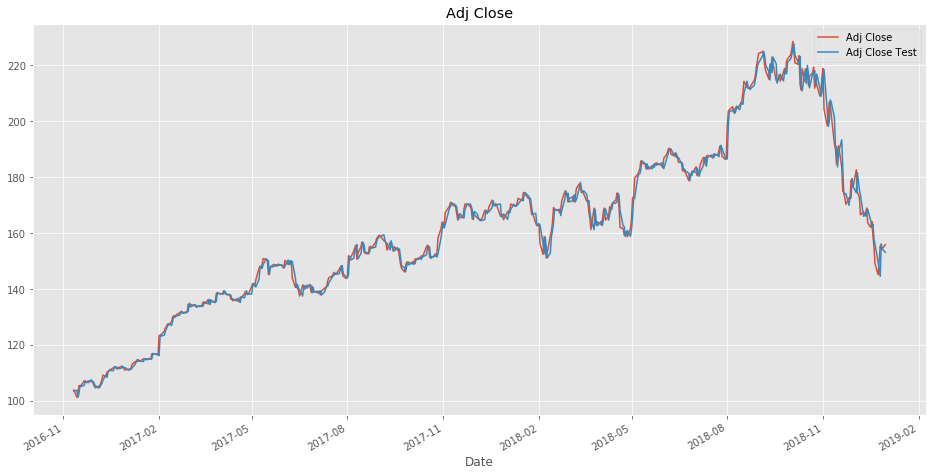

In [12]:
df_linear_test = df_stock.copy()
df_linear_test.drop(['Open', 'High', 'Low', 'Close', 'Volume','Daily % change close','Moving average','% change moving average','Prediction Linear Regression (Price)','Prediction Lasso (Price)','Prediction Ridge (Price)'], axis=1, inplace=True)
df_linear_test = df_linear_test.iloc[time_horizon_predictions+train_length:] 
df_linear_test['Adj Close Test'] = y_pred_linear
df_linear_test.plot(label=ticker, figsize=(16,8), title=Closing_price, grid=True)

$R^{2}$

In [13]:
r_sq_linear = linear_model.score(X_test, y_test)
print('coefficient of determination:', r_sq_linear)

coefficient of determination: 0.9923430563202522


# Method 2 Ridge regression

In [14]:
# Train
Ridge_model = sklearn.linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13))
Ridge_model.fit(X_train, y_train)

# Infer
y_pred_train_Ridge = Ridge_model.predict(X_train)
y_pred_Ridge = Ridge_model.predict(X_test)

Plot prediction for training data

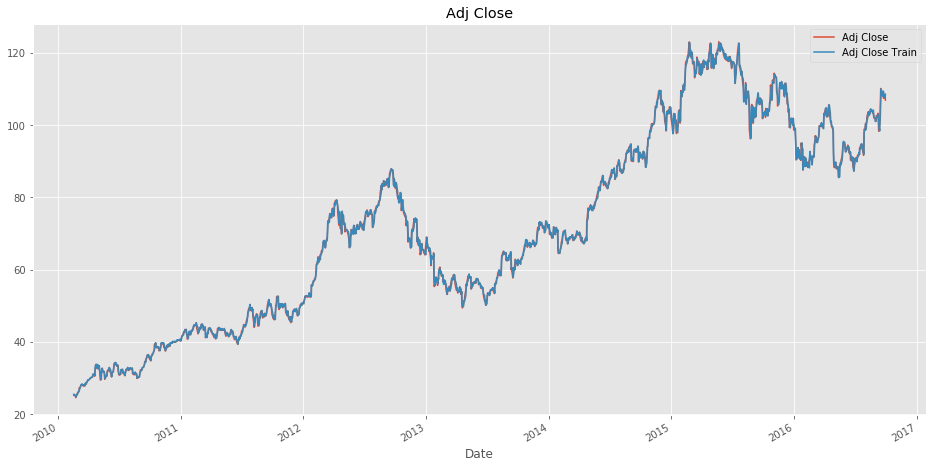

In [15]:
# Plot what it looks like for the training data
df_Ridge_train = df_stock.copy()
df_Ridge_train.drop(['Open', 'High', 'Low', 'Close', 'Volume','Daily % change close','Moving average','% change moving average','Prediction Linear Regression (Price)','Prediction Lasso (Price)','Prediction Ridge (Price)'], axis=1, inplace=True)
df_Ridge_train = df_Ridge_train.iloc[time_horizon_predictions:train_length] 
df_Ridge_train['Adj Close Train'] = y_pred_train_Ridge[:-time_horizon_predictions]
df_Ridge_train.plot(label=ticker, figsize=(16,8), title=Closing_price, grid=True)

Plot prediction for test data

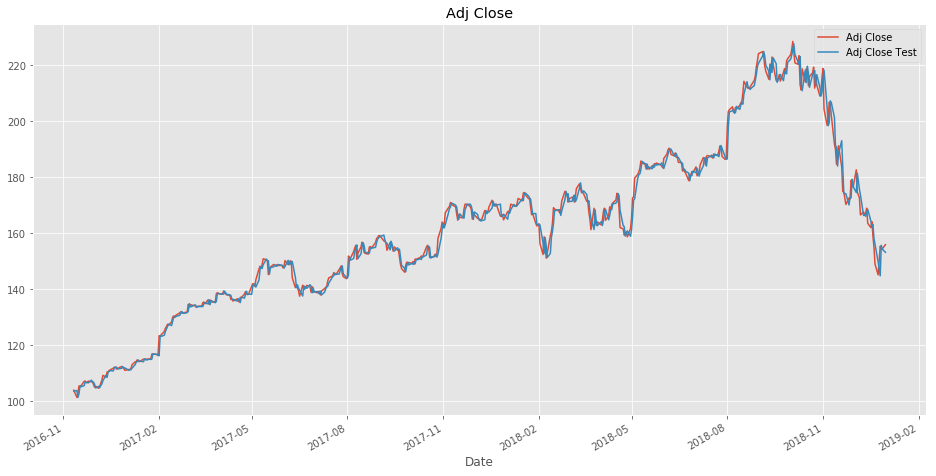

In [16]:
df_Ridge_test = df_stock.copy()
df_Ridge_test.drop(['Open', 'High', 'Low', 'Close', 'Volume','Daily % change close','Moving average','% change moving average','Prediction Linear Regression (Price)','Prediction Lasso (Price)','Prediction Ridge (Price)'], axis=1, inplace=True)
df_Ridge_test = df_Ridge_test.iloc[time_horizon_predictions+train_length:] 
df_Ridge_test['Adj Close Test'] = y_pred_Ridge
df_Ridge_test.plot(label=ticker, figsize=(16,8), title=Closing_price, grid=True)

$R^{2}$

In [17]:
r_sq_Ridge = Ridge_model.score(X_test, y_test)
print('coefficient of determination:', r_sq_Ridge)

coefficient of determination: 0.9923361796793757


# Method 3 Lasso regression

In [18]:
# Train
Lasso_model = sklearn.linear_model.LassoCV(cv=20)
Lasso_model.fit(X_train, y_train)

# Infer
y_pred_train_Lasso = Lasso_model.predict(X_train)
y_pred_Lasso = Lasso_model.predict(X_test)

Plot prediction for training data

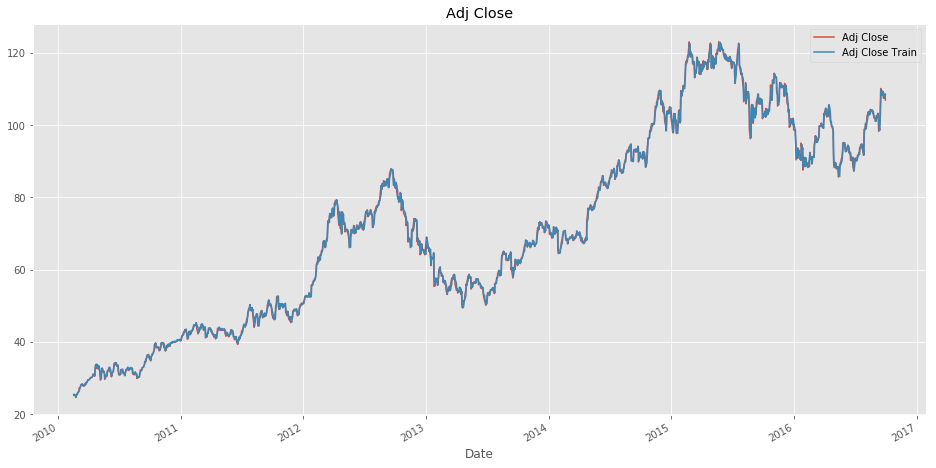

In [19]:
# Plot what it looks like for the training data
df_Lasso_train = df_stock.copy()
df_Lasso_train.drop(['Open', 'High', 'Low', 'Close', 'Volume','Daily % change close','Moving average','% change moving average','Prediction Linear Regression (Price)','Prediction Lasso (Price)','Prediction Ridge (Price)'], axis=1, inplace=True)
df_Lasso_train = df_Lasso_train.iloc[time_horizon_predictions:train_length] 
df_Lasso_train['Adj Close Train'] = y_pred_train_Lasso[:-time_horizon_predictions]
df_Lasso_train.plot(label=ticker, figsize=(16,8), title=Closing_price, grid=True)

Plot prediction for test data

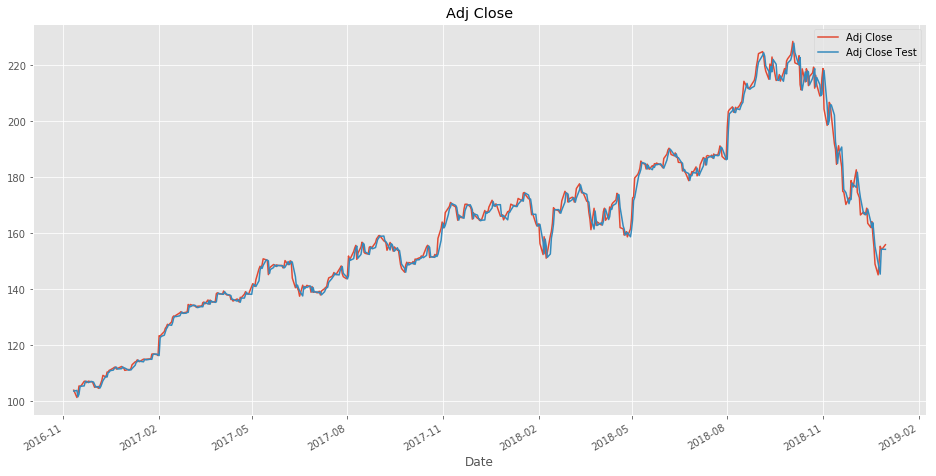

In [20]:
df_Lasso_test = df_stock.copy()
df_Lasso_test.drop(['Open', 'High', 'Low', 'Close', 'Volume','Daily % change close','Moving average','% change moving average','Prediction Linear Regression (Price)','Prediction Lasso (Price)','Prediction Ridge (Price)'], axis=1, inplace=True)
df_Lasso_test = df_Lasso_test.iloc[time_horizon_predictions+train_length:] 
df_Lasso_test['Adj Close Test'] = y_pred_Lasso
df_Lasso_test.plot(label=ticker, figsize=(16,8), title=Closing_price, grid=True)

$R^{2}$

In [21]:
r_sq_Lasso = Lasso_model.score(X_test, y_test)
print('coefficient of determination:', r_sq_Lasso)

coefficient of determination: 0.9923653136909543


Add the results to the data frame

In [22]:
result_linear = np.concatenate((y_pred_train_linear,y_pred_linear))
result_ridge = np.concatenate((y_pred_train_Ridge,y_pred_Ridge))
result_lasso = np.concatenate((y_pred_train_Lasso,y_pred_Lasso))

sources = [result_linear,result_ridge,result_lasso]
columns = ['Prediction Linear Regression (Price)','Prediction Ridge (Price)','Prediction Lasso (Price)']
for j in range(len(columns)):
    for i in range(len(result_linear)):
        df_stock[columns[j]].values[i+time_horizon_predictions] = sources[j][i]
        
df_stock.tail()

,High,Low,Open,Close,Volume,Adj Close,Daily % change close,Moving average,% change moving average,Prediction Linear Regression (Price),Prediction Lasso (Price),Prediction Ridge (Price)
Date,,,,,,,,,,,,
2018-12-24,151.550003,146.589996,148.149994,146.830002,37169200.0,145.090836,-0.025874,160.026796,-0.013865,149,149,149
2018-12-26,157.229996,146.720001,148.300003,157.169998,58582500.0,155.308350,0.070421,158.894370,-0.007076,144,145,144
2018-12-27,156.770004,150.070007,155.839996,156.149994,53117100.0,154.300446,-0.006490,157.614709,-0.008054,156,154,155
2018-12-28,158.520004,154.550003,157.500000,156.229996,42291400.0,154.379486,0.000512,156.160146,-0.009229,154,154,154
2018-12-31,159.360001,156.479996,158.529999,157.740005,35003500.0,155.871613,0.009665,155.395316,-0.004898,153,154,153
